In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import matplotlib.patches as mpatches

deeploc=pd.read_csv(r'd:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\localisation\all\deeploc2_out.csv')
asafind=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\localisation\all\asafind.tab', sep='\t')
targetp=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\localisation\all\trinity_out_dir.Trinity.fasta.transdecoder_summary.targetp', sep='\t',skiprows=1)

Count number of plastid targeted
---

In [2]:
# Concatenate the DataFrames along the rows
result = targetp.iloc[:, [0, 1]].merge(asafind.iloc[:, [0, 6]], left_on=targetp.columns[0], right_on=asafind.columns[0], how='left').merge(deeploc.iloc[:, [0, 1]], left_on=targetp.columns[0], right_on=deeploc.columns[0], how='left')
result=result.iloc[:,[0,1,3,5]]
result= result.rename(columns={'# ID': 'Protien ID', 'Prediction': 'TargetP2', 'ASAFind 2.0_beta25 Prediction, score threshold = 0.3100298026055153, with FWYL check': 'ASAFind2','Localizations': 'DeepLoc2'})
csv_out=r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\localisation\all\result.csv'
#result.to_csv(csv_out,sep=',',index=False)


Counts

In [3]:
asa_hit_count = (result.iloc[:, 2].str.contains("confidence") & (~result.iloc[:, 1].astype(str).str.contains("cTP|luTP")) & (~result.iloc[:, 3].astype(str).str.contains("Plastid"))).sum()
deeploc_hit_count = (result.iloc[:, 3].str.contains("Plastid") & (~result.iloc[:, 2].astype(str).str.contains("confidence")) & (~result.iloc[:, 1].astype(str).str.contains("cTP|luTP"))).sum()
asa_deep_count = (result.iloc[:, 2].str.contains("confidence") & result.iloc[:, 3].str.contains("Plastid") & (~result.iloc[:, 1].astype(str).str.contains("cTP|luTP"))).sum()
targetp_hit_count = (result.iloc[:, 1].str.contains("cTP|luTP") & (~result.iloc[:, 3].astype(str).str.contains("Plastid")) & (~result.iloc[:, 2].astype(str).str.contains("confidence"))).sum()
asa_targetp_count = (result.iloc[:, 2].str.contains("confidence") & result.iloc[:, 1].str.contains("cTP|luTP") & (~result.iloc[:, 3].astype(str).str.contains("Plastid"))).sum()
targetp_deep_count = (result.iloc[:, 1].str.contains("cTP|luTP") & result.iloc[:, 3].str.contains("Plastid")& (~result.iloc[:, 2].astype(str).str.contains("confidence"))).sum()
all_hit_count = (result.iloc[:, 2].str.contains("confidence") & result.iloc[:, 1].str.contains("cTP|luTP") & result.iloc[:, 3].str.contains("Plastid")).sum()

Text(0.5, 1.0, 'Plastid targeting prediction')

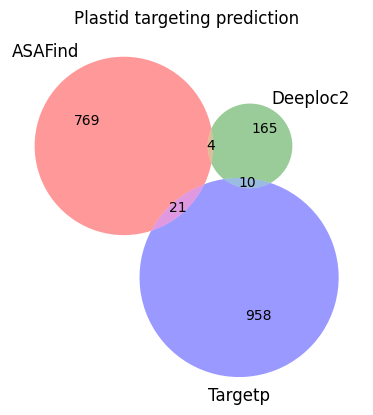

In [4]:
venn3(subsets = (asa_hit_count, deeploc_hit_count, asa_deep_count, targetp_hit_count, asa_targetp_count, targetp_deep_count, all_hit_count), set_labels = ('ASAFind', 'Deeploc2', 'Targetp'))
plt.title("Plastid targeting prediction")
#plt.savefig("plastid_target.svg")

Predicted by 2

In [6]:
two_hit = result[
    (result.iloc[:, 2].str.contains("confidence").astype(int) + 
     result.iloc[:, 3].str.contains("Plastid").astype(int) + 
     result.iloc[:, 1].str.contains("cTP|luTP").astype(int)) >= 2
]
annotate=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\trinity_out_dir.Trinity_trinotate_annotation_report.tsv', sep='\t')
two_hit_annotate = two_hit.merge(annotate, left_on='Protien ID', right_on='prot_id', how='left')
#two_hit_annotate.to_csv('two_hit_annotate.csv',sep=',',index=False)

In [7]:
any_hit = result[
    (result.iloc[:, 2].str.contains("confidence").astype(int) + 
     result.iloc[:, 3].str.contains("Plastid").astype(int) + 
     result.iloc[:, 1].str.contains("cTP|luTP").astype(int)) >= 1
]

any_hit_annotate = any_hit.merge(annotate, left_on='Protien ID', right_on='prot_id', how='left')


In [8]:
count_blastx=sum(1 for hit in any_hit_annotate['gene_ontology_BLASTX'] if '.' not in hit)
count_blastp=sum(1 for hit in any_hit_annotate['gene_ontology_BLASTP'] if '.' not in hit)
count_pfam=sum(1 for hit in any_hit_annotate['gene_ontology_Pfam'] if '.' not in hit)
count_COG = sum(1 for hit in any_hit_annotate['eggnog'] if '.' not in hit)
print('blastp annotated transcripts:',count_blastp)
print('blastx annotated transcripts:',count_blastx)
print('pfam annotated transcripts:',count_pfam)
print('COG annotated transcripts:',count_COG)

any_hit_annotate['gene_ontology'] = (any_hit_annotate['gene_ontology_BLASTX']
    .fillna(annotate['gene_ontology_BLASTP'])
    .fillna(annotate['gene_ontology_Pfam']))

blastp annotated transcripts: 507
blastx annotated transcripts: 569
pfam annotated transcripts: 410
COG annotated transcripts: 90


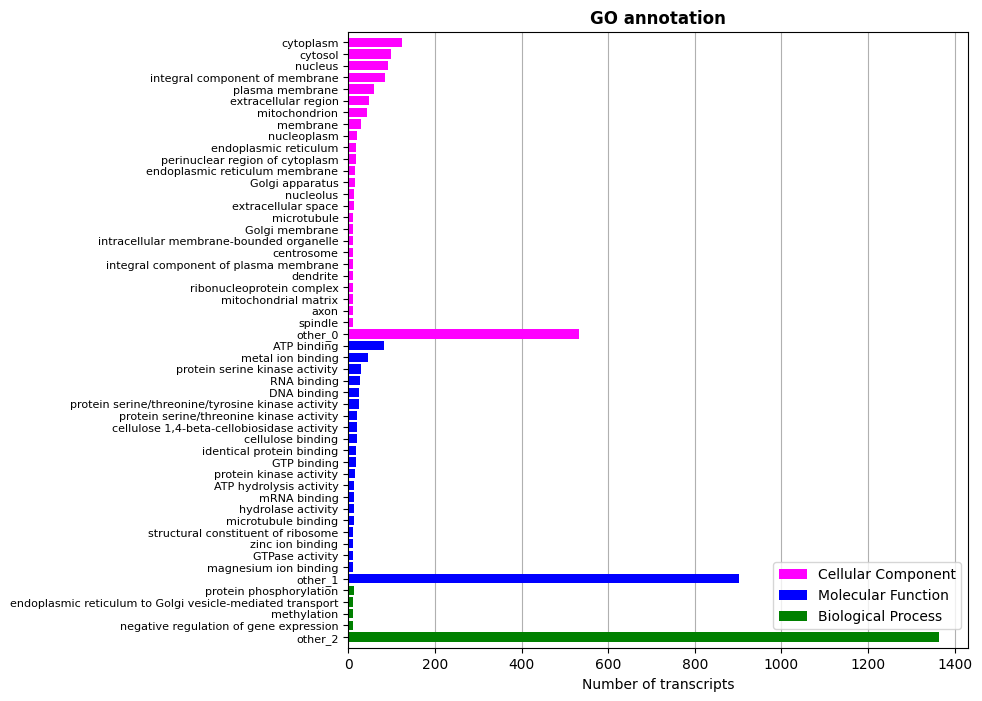

In [9]:
def comb_go(df, title='GO annotation', o=10):
    cc_lis = df['gene_ontology'].str.findall(r'(?<=cellular_component\^)(.*?)(?=\`|\n)').dropna()
    mf_lis = df['gene_ontology'].str.findall(r'(?<=molecular_function\^)(.*?)(?=\`|\n)').dropna()
    bp_lis = df['gene_ontology'].str.findall(r'(?<=biological_process\^)(.*?)(?=\`|\n)').dropna()
    # create a list of dictionaries
    dict_list = [cc_lis, mf_lis, bp_lis]
    # count the number of occurrences of each key in each list
    key_counts_list = []

    for dic_no, d in enumerate(dict_list):
        key_counts = {}
        other_count = {}
        for i in d:
            if not i:  # Skip the iteration if i is empty
                continue
            for key in i:
                key_counts[key] = key_counts.get(key, 0) + 1
        sorted_key_counts = sorted(key_counts.items(), key=lambda item: item[1], reverse=True)
        key_counts = {k: v for k, v in sorted_key_counts if v >= o}
        other_count = {k: v for k, v in sorted_key_counts if v < o}
        key_counts[f"other_{dic_no}"] = sum(other_count.values())
        key_counts_list.append(key_counts)
        #print(key_counts)

    # create a figure for combined plot
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = ['magenta', 'blue', 'green']
    # plot a bar chart for each dictionary
    for i, key_counts in enumerate(key_counts_list):
        labels = list(key_counts.keys())
        values = list(key_counts.values())
        ax.barh(labels, values, color=colors[i], label=['Cellular Component', 
                                                        'Molecular Function', 
                                                        'Biological Process'][i],zorder=2)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(visible=True,which='major',axis='x',zorder=0)
    ax.legend(loc=0, bbox_to_anchor=(1,0.15))
    ax.set_xlabel('Number of transcripts')
    ax.invert_yaxis()
    ax.tick_params(axis='y', labelsize=8)
    ax.margins(y=0.01)
comb_go(any_hit_annotate)

COG annotation graph

In [10]:
cogid=pd.read_csv('cog-20.def.tab', sep='\t', header=None, encoding='latin1')
fun=pd.read_csv(r'd:\Uni\Programmes\COG\fun.txt', sep='\t', header=None)
any_hit_annotate['COG'] = any_hit_annotate['eggnog'].str.split('^').str.get(0)

In [10]:
f = open("anyhit.txt", "w")
f.write('\n'.join(any_hit_annotate['Protien ID'].astype(str)))

f.close()

COG annotation of plastid targeting genes(anyhit.txt) was done using http://eggnog-mapper.embl.de/

In [11]:
merged = pd.merge(
    any_hit_annotate, cogid, left_on='COG', right_on=0,validate='m:1')
merged[1] = merged[1].apply(list)
merged = merged.explode(1)
merged = pd.merge(merged, fun, left_on=1, right_on=1)[['Protien ID','COG',1,'0_y','2_y']]
fun_explanation = ("[" + merged[1].astype(str) + "] " + merged['2_y'].astype(str)).drop_duplicates().sort_values()

In [12]:
eggnog = pd.read_csv(r"d:/Uni/Dino/Projects/Sino/Transcriptome/clean_1234/localisation/all/MM_ixtxvcev.emapper.annotations.tsv", sep='\t', skiprows=4, skipfooter=3, engine='python')
eggnog['COG_category'] = eggnog['COG_category'].apply(list)
eggnog = eggnog.explode('COG_category')
eggnog_m = pd.merge(eggnog, fun, left_on='COG_category', right_on=1)[['#query','COG_category',0,2]]
fun_explanation = ("[" + eggnog_m['COG_category'].astype(str) + "] " + eggnog_m[2].astype(str)).drop_duplicates().sort_values()


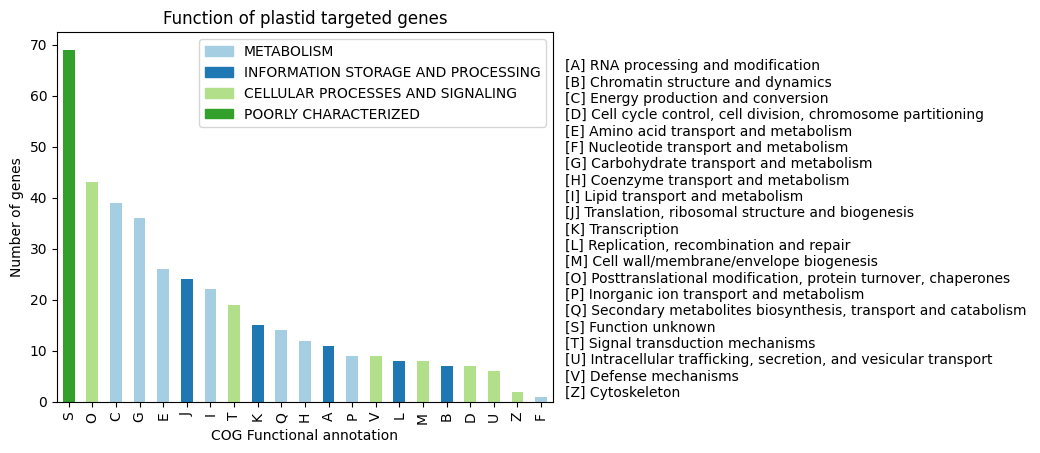

In [13]:
def plot_bargraph_with_groupings(df, groupby, colourby, title, xlabel, ylabel):
    """
    Plots a dataframe showing the frequency of datapoints grouped by one column and coloured by another.
    df : dataframe
    groupby: the column to groupby
    colourby: the column to color by
    title: the graph title
    xlabel: the x label,
    ylabel: the y label
    """
    # Makes a mapping from the unique colourby column items to a random color.
    ind_col_map = {x:y for x, y in zip(df[colourby].unique(),
                               [plt.cm.Paired(np.arange(len(df[colourby].unique())))][0])}

    # Find when the indicies of the soon to be bar graphs colors.
    unique_comb = df[[groupby, colourby]].drop_duplicates()
    name_ind_map = {x:y for x, y in zip(unique_comb[groupby], unique_comb[colourby])}
    c = df[groupby].value_counts().index.map(lambda x: ind_col_map[name_ind_map[x]])

    # Makes the bargraph.
    ax = df[groupby].value_counts().plot(kind='bar',
                                         title=title,
                                         color=c.values)
    # Makes a legend using the ind_col_map
    legend_list = []
    for key in ind_col_map.keys():
        legend_list.append(mpatches.Patch(color=ind_col_map[key], label=key))
    
    #add COG lables to side
    
    y=65
    x=21
    for i, explanation in enumerate(fun_explanation):
        plt.text(x, y-i*3.2, str(explanation))

    # display the graph.
    plt.legend(handles=legend_list, loc=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plot_bargraph_with_groupings(eggnog_m,'COG_category',0,'Function of plastid targeted genes','COG Functional annotation','Number of genes')
plt.savefig("COG_plastid.svg")

Number of mitochondria
---

In [ ]:
result_m = targetp.merge(deeploc.iloc[:, [0, 1]], left_on=targetp.columns[0], right_on=deeploc.columns[0], how='left')
result_m=result_m.iloc[:,[0,1,9]]
deeploc_mhit_count = (result_m.iloc[:, 2].str.contains("Mitocho").sum())
targetp_mhit_count = (result_m.iloc[:, 1].str.contains("mTP").sum())
targetp_deep_mhit_count = (result_m.iloc[:, 1].str.contains("mTP") & result_m.iloc[:, 2].str.contains("Mitocho")).sum()
result_m_table = result_m[(result_m.iloc[:, 2].str.contains("Mitocho") | result_m.iloc[:, 1].str.contains("mTP"))]

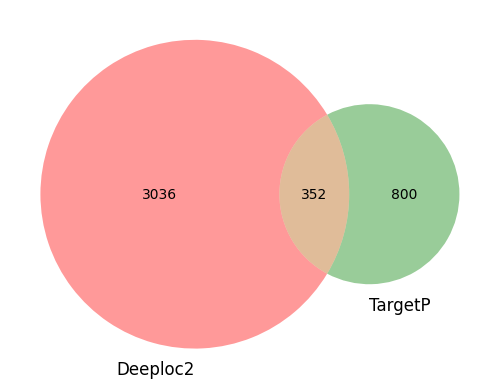

In [15]:
venn2(subsets = (deeploc_mhit_count - targetp_deep_mhit_count, targetp_mhit_count - targetp_deep_mhit_count, targetp_deep_mhit_count), set_labels = ('Deeploc2', 'TargetP'))
result_m_table_annotate= pd.merge(result_m_table, annotate, left_on='# ID',right_on='prot_id')
csv_out=r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\localisation\all\mito_hits.csv'
result_m_table_annotate.to_csv(csv_out,sep=',',index=False)
#plt.savefig("mito_target.svg")

Include abundance count